# Reinforce with baseline algorithm



*   Monte Carlo plays out the whole trajectory in an episode
that is used to update the policy afterward.
*   However, the stochastic policy may take
different actions at the same state in different episodes
*   This can confuse the training, since
one sampled experience wants to increase the probability of choosing one action while
another sampled experience may want to decrease it.
*   We need to reduce this high variance problem in Vnilla Reinforce algo
*   with baseline, we subtract the baseline state-value from the return, G.
*   As a
result, we use an advantage function A in the gradient update
*   At = Gt - V(st) , V(s) is a value function which estimates the state value given a state.

## REINFORCE with BASELINE use two neural networks, one for policy and another one for value estimation


In [2]:
# Importing Libraries and cartpole env
import torch
import gym
import torch.nn as nn
from torch.autograd import Variable


env = gym.make('CartPole-v0')

# PolicyNetwork Class

In [3]:
class PolicyNetwork():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):

        self.model = nn.Sequential(
                        nn.Linear(n_state, n_hidden),
                        nn.ReLU(),
                        nn.Linear(n_hidden, n_action),
                        nn.Softmax(),
                )

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)


    def predict(self, s):
        """
        Compute the action probabilities of state s using the learning model
        @param s: input state
        @return: predicted policy
        """
        return self.model(torch.Tensor(s))


    def update(self, advantages, log_probs):
        """
        Update the weights of the policy network given the training samples
        @param advantages: advantage for each step in an episode
        @param log_probs: log probability for each step
        """
        policy_gradient = []
        for log_prob, Gt in zip(log_probs, advantages):
            policy_gradient.append(-log_prob * Gt)

        loss = torch.stack(policy_gradient).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def get_action(self, s):
        """
        Estimate the policy and sample an action, compute its log probability
        @param s: input state
        @return: the selected action and log probability
        """
        probs = self.predict(s)
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs[action])
        return action, log_prob
    



# Value Network

## Use of Regression Neural Network with one hidden layer

In [5]:
class ValueNetwork():
    def __init__(self, n_state, n_hidden=50, lr=0.05):
        self.criterion = torch.nn.MSELoss() # Its learning goal is to approximate state-values; hence, we use the mean squared
                                            # error as the loss function.
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(n_state, n_hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden, 1)
                )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    """
    The update method trains the value regression model with a set of input states
    and target outputs, via backpropagation of course.
    """

    def update(self, s, y):
        """
        Update the weights of the DQN given a training sample
        @param s: states
        @param y: target values
        """
        y_pred = self.model(torch.Tensor(s))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    # the predict method estimates the state-value:
    def predict(self, s):
        """
        Compute the Q values of the state for all actions using the learning model
        @param s: input state
        @return: Q values of the state for all actions
        """
        with torch.no_grad():
            return self.model(torch.Tensor(s))


# REINFORCE with BASELINE algorithm with a policy and value network model

In [8]:
def reinforce(env, estimator_policy, estimator_value, n_episode, gamma=1.0):
    """
    REINFORCE algorithm with baseline
    @param env: Gym environment
    @param estimator_policy: policy network
    @param estimator_value: value network
    @param n_episode: number of episodes
    @param gamma: the discount factor
    """
    for episode in range(n_episode):
        log_probs = []
        states = []
        rewards = []
        state = env.reset()

        while True:
            states.append(state)
            action, log_prob = estimator_policy.get_action(state)
            next_state, reward, is_done, _ = env.step(action)

            total_reward_episode[episode] += reward
            log_probs.append(log_prob)

            rewards.append(reward)

            if is_done:
                Gt = 0
                pw = 0

                returns = []
                for t in range(len(states)-1, -1, -1):
                    Gt += gamma ** pw * rewards[t]
                    pw += 1
                    returns.append(Gt)


                returns = returns[::-1]
                returns = torch.tensor(returns)

                baseline_values = estimator_value.predict(states)

                advantages = returns - baseline_values


                estimator_value.update(states, returns)

                estimator_policy.update(advantages, log_probs)


                print('Episode: {}, total reward: {}'.format(episode, total_reward_episode[episode]))
                break


            state = next_state



In [9]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden_p = 64
lr_p = 0.003
policy_net = PolicyNetwork(n_state, n_action, n_hidden_p, lr_p)

n_hidden_v = 64
lr_v = 0.003
value_net = ValueNetwork(n_state, n_hidden_v, lr_v)

n_episode = 2000
gamma = 0.9
total_reward_episode = [0] * n_episode

In [10]:
reinforce(env, policy_net, value_net, n_episode, gamma)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([56])) that is different to the input size (torch.Size([56, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 0, total reward: 56.0
Episode: 1, total reward: 52.0
Episode: 2, total reward: 67.0
Episode: 3, total reward: 25.0
Episode: 4, total reward: 14.0
Episode: 5, total reward: 31.0
Episode: 6, total reward: 15.0
Episode: 7, total reward: 20.0
Episode: 8, total reward: 10.0
Episode: 9, total reward: 31.0
Episode: 10, total reward: 33.0
Episode: 11, total reward: 14.0
Episode: 12, total reward: 21.0
Episode: 13, total reward: 21.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([67])) that is different to the input size (torch.Size([67, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Episode: 14, total reward: 29.0
Episode: 15, total reward: 16.0
Episode: 16, total reward: 17.0
Episode: 17, total reward: 15.0
Episode: 18, total reward: 41.0
Episode: 19, total reward: 42.0
Episode: 20, total reward: 15.0
Episode: 21, total reward: 19.0
Episode: 22, total reward: 15.0
Episode: 23, total reward: 45.0
Episode: 24, total reward: 36.0
Episode: 25, total reward: 33.0
Episode: 26, total reward: 24.0
Episode: 27, total reward: 87.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([41])) that is different to the input size (torch.Size([41, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Episode: 28, total reward: 37.0
Episode: 29, total reward: 22.0
Episode: 30, total reward: 36.0
Episode: 31, total reward: 26.0
Episode: 32, total reward: 14.0
Episode: 33, total reward: 40.0
Episode: 34, total reward: 33.0
Episode: 35, total reward: 30.0
Episode: 36, total reward: 49.0
Episode: 37, total reward: 18.0
Episode: 38, total reward: 29.0
Episode: 39, total reward: 18.0
Episode: 40, total reward: 20.0
Episode: 41, total reward: 41.0
Episode: 42, total reward: 11.0
Episode: 43, total reward: 10.0
Episode: 44, total reward: 30.0
Episode: 45, total reward: 31.0
Episode: 46, total reward: 49.0
Episode: 47, total reward: 15.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Episode: 48, total reward: 13.0
Episode: 49, total reward: 19.0
Episode: 50, total reward: 13.0
Episode: 51, total reward: 17.0
Episode: 52, total reward: 44.0
Episode: 53, total reward: 20.0
Episode: 54, total reward: 12.0
Episode: 55, total reward: 23.0
Episode: 56, total reward: 10.0
Episode: 57, total reward: 63.0
Episode: 58, total reward: 17.0
Episode: 59, total reward: 18.0
Episode: 60, total reward: 81.0
Episode: 61, total reward: 34.0
Episode: 62, total reward: 25.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([44])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Episode: 63, total reward: 54.0
Episode: 64, total reward: 30.0
Episode: 65, total reward: 25.0
Episode: 66, total reward: 42.0
Episode: 67, total reward: 19.0
Episode: 68, total reward: 27.0
Episode: 69, total reward: 19.0
Episode: 70, total reward: 86.0
Episode: 71, total reward: 15.0
Episode: 72, total reward: 26.0
Episode: 73, total reward: 13.0
Episode: 74, total reward: 9.0
Episode: 75, total reward: 102.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([86])) that is different to the input size (torch.Size([86, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targ

Episode: 76, total reward: 21.0
Episode: 77, total reward: 18.0
Episode: 78, total reward: 29.0
Episode: 79, total reward: 21.0
Episode: 80, total reward: 40.0
Episode: 81, total reward: 47.0
Episode: 82, total reward: 36.0
Episode: 83, total reward: 55.0
Episode: 84, total reward: 69.0
Episode: 85, total reward: 81.0
Episode: 86, total reward: 17.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([47])) that is different to the input size (torch.Size([47, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([69])) that is different to the input size (torch.Size([69, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Episode: 87, total reward: 26.0
Episode: 88, total reward: 27.0
Episode: 89, total reward: 72.0
Episode: 90, total reward: 22.0
Episode: 91, total reward: 31.0
Episode: 92, total reward: 11.0
Episode: 93, total reward: 41.0
Episode: 94, total reward: 25.0
Episode: 95, total reward: 33.0
Episode: 96, total reward: 18.0
Episode: 97, total reward: 59.0
Episode: 98, total reward: 75.0
Episode: 99, total reward: 13.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([59])) that is different to the input size (torch.Size([59, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([75])) that is different to the input size (torch.Size([75, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Episode: 100, total reward: 50.0
Episode: 101, total reward: 115.0
Episode: 102, total reward: 11.0
Episode: 103, total reward: 20.0
Episode: 104, total reward: 36.0
Episode: 105, total reward: 16.0
Episode: 106, total reward: 36.0
Episode: 107, total reward: 46.0
Episode: 108, total reward: 34.0
Episode: 109, total reward: 25.0
Episode: 110, total reward: 21.0
Episode: 111, total reward: 25.0
Episode: 112, total reward: 37.0
Episode: 113, total reward: 35.0
Episode: 114, total reward: 11.0
Episode: 115, total reward: 29.0
Episode: 116, total reward: 28.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([79])) that is different to the input size (torch.Size([79, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Episode: 117, total reward: 79.0
Episode: 118, total reward: 24.0
Episode: 119, total reward: 53.0
Episode: 120, total reward: 53.0
Episode: 121, total reward: 87.0
Episode: 122, total reward: 15.0
Episode: 123, total reward: 43.0
Episode: 124, total reward: 11.0
Episode: 125, total reward: 44.0
Episode: 126, total reward: 37.0
Episode: 127, total reward: 65.0
Episode: 128, total reward: 61.0
Episode: 129, total reward: 25.0
Episode: 130, total reward: 31.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([65])) that is different to the input size (torch.Size([65, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([61])) that is different to the input size (torch.Size([61, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([38])) that is different to the input size (torch.Size([38, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Episode: 131, total reward: 23.0
Episode: 132, total reward: 54.0
Episode: 133, total reward: 29.0
Episode: 134, total reward: 24.0
Episode: 135, total reward: 36.0
Episode: 136, total reward: 29.0
Episode: 137, total reward: 38.0
Episode: 138, total reward: 21.0
Episode: 139, total reward: 16.0
Episode: 140, total reward: 37.0
Episode: 141, total reward: 32.0
Episode: 142, total reward: 47.0
Episode: 143, total reward: 40.0
Episode: 144, total reward: 20.0
Episode: 145, total reward: 33.0
Episode: 146, total reward: 16.0
Episode: 147, total reward: 14.0
Episode: 148, total reward: 32.0
Episode: 149, total reward: 27.0
Episode: 150, total reward: 75.0
Episode: 151, total reward: 15.0
Episode: 152, total reward: 23.0
Episode: 153, total reward: 34.0
Episode: 154, total reward: 51.0
Episode: 155, total reward: 47.0
Episode: 156, total reward: 47.0
Episode: 157, total reward: 46.0
Episode: 158, total reward: 48.0
Episode: 159, total reward: 184.0
Episode: 160, total reward: 40.0
Episode: 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([51])) that is different to the input size (torch.Size([51, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([184])) that is different to the input size (torch.Size([184, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, 

Episode: 162, total reward: 42.0
Episode: 163, total reward: 44.0
Episode: 164, total reward: 19.0
Episode: 165, total reward: 79.0
Episode: 166, total reward: 94.0
Episode: 167, total reward: 55.0
Episode: 168, total reward: 84.0
Episode: 169, total reward: 84.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([94])) that is different to the input size (torch.Size([94, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([84])) that is different to the input size (torch.Size([84, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Episode: 170, total reward: 60.0
Episode: 171, total reward: 25.0
Episode: 172, total reward: 61.0
Episode: 173, total reward: 36.0
Episode: 174, total reward: 58.0
Episode: 175, total reward: 19.0
Episode: 176, total reward: 43.0
Episode: 177, total reward: 37.0
Episode: 178, total reward: 29.0
Episode: 179, total reward: 63.0
Episode: 180, total reward: 60.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([151])) that is different to the input size (torch.Size([151, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([147])) that is different to the input size (torch.Size([147, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([117])) that is different to the input size (torch.Size([117, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inp

Episode: 181, total reward: 151.0
Episode: 182, total reward: 44.0
Episode: 183, total reward: 147.0
Episode: 184, total reward: 56.0
Episode: 185, total reward: 117.0
Episode: 186, total reward: 76.0
Episode: 187, total reward: 67.0
Episode: 188, total reward: 49.0
Episode: 189, total reward: 65.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([91])) that is different to the input size (torch.Size([91, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([154])) that is different to the input size (torch.Size([154, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 190, total reward: 91.0
Episode: 191, total reward: 25.0
Episode: 192, total reward: 45.0
Episode: 193, total reward: 30.0
Episode: 194, total reward: 154.0
Episode: 195, total reward: 50.0
Episode: 196, total reward: 36.0
Episode: 197, total reward: 42.0
Episode: 198, total reward: 27.0
Episode: 199, total reward: 42.0
Episode: 200, total reward: 58.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([130])) that is different to the input size (torch.Size([130, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([114])) that is different to the input size (torch.Size([114, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([88])) that is different to the input size (torch.Size([88, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input

Episode: 201, total reward: 130.0
Episode: 202, total reward: 114.0
Episode: 203, total reward: 56.0
Episode: 204, total reward: 88.0
Episode: 205, total reward: 94.0
Episode: 206, total reward: 90.0
Episode: 207, total reward: 200.0
Episode: 208, total reward: 40.0
Episode: 209, total reward: 47.0
Episode: 210, total reward: 109.0
Episode: 211, total reward: 55.0
Episode: 212, total reward: 105.0
Episode: 213, total reward: 34.0
Episode: 214, total reward: 100.0
Episode: 215, total reward: 97.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([109])) that is different to the input size (torch.Size([109, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([105])) that is different to the input size (torch.Size([105, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inp

Episode: 216, total reward: 27.0
Episode: 217, total reward: 48.0
Episode: 218, total reward: 37.0
Episode: 219, total reward: 86.0
Episode: 220, total reward: 94.0
Episode: 221, total reward: 76.0
Episode: 222, total reward: 95.0
Episode: 223, total reward: 91.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([95])) that is different to the input size (torch.Size([95, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([98])) that is different to the input size (torch.Size([98, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([108])) that is different to the input size (torch.Size([108, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, 

Episode: 224, total reward: 98.0
Episode: 225, total reward: 81.0
Episode: 226, total reward: 108.0
Episode: 227, total reward: 140.0
Episode: 228, total reward: 76.0
Episode: 229, total reward: 48.0
Episode: 230, total reward: 26.0
Episode: 231, total reward: 96.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([96])) that is different to the input size (torch.Size([96, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([120])) that is different to the input size (torch.Size([120, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([68])) that is different to the input size (torch.Size([68, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, 

Episode: 232, total reward: 48.0
Episode: 233, total reward: 27.0
Episode: 234, total reward: 120.0
Episode: 235, total reward: 68.0
Episode: 236, total reward: 98.0
Episode: 237, total reward: 91.0
Episode: 238, total reward: 62.0
Episode: 239, total reward: 109.0
Episode: 240, total reward: 55.0
Episode: 241, total reward: 142.0
Episode: 242, total reward: 80.0
Episode: 243, total reward: 75.0
Episode: 244, total reward: 102.0
Episode: 245, total reward: 155.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([142])) that is different to the input size (torch.Size([142, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([80])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([155])) that is different to the input size (torch.Size([155, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input

Episode: 246, total reward: 180.0
Episode: 247, total reward: 169.0
Episode: 248, total reward: 159.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([169])) that is different to the input size (torch.Size([169, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([159])) that is different to the input size (torch.Size([159, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([195])) that is different to the input size (torch.Size([195, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inp

Episode: 249, total reward: 195.0
Episode: 250, total reward: 120.0
Episode: 251, total reward: 189.0
Episode: 252, total reward: 200.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([189])) that is different to the input size (torch.Size([189, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([57])) that is different to the input size (torch.Size([57, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 253, total reward: 130.0
Episode: 254, total reward: 91.0
Episode: 255, total reward: 57.0
Episode: 256, total reward: 68.0
Episode: 257, total reward: 140.0
Episode: 258, total reward: 108.0
Episode: 259, total reward: 55.0
Episode: 260, total reward: 95.0
Episode: 261, total reward: 88.0
Episode: 262, total reward: 92.0
Episode: 263, total reward: 157.0
Episode: 264, total reward: 64.0
Episode: 265, total reward: 155.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([92])) that is different to the input size (torch.Size([92, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([157])) that is different to the input size (torch.Size([157, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, 

Episode: 266, total reward: 169.0
Episode: 267, total reward: 168.0
Episode: 268, total reward: 68.0
Episode: 269, total reward: 132.0
Episode: 270, total reward: 200.0
Episode: 271, total reward: 31.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([168])) that is different to the input size (torch.Size([168, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([132])) that is different to the input size (torch.Size([132, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 272, total reward: 140.0
Episode: 273, total reward: 200.0
Episode: 274, total reward: 200.0
Episode: 275, total reward: 200.0
Episode: 276, total reward: 200.0
Episode: 277, total reward: 99.0
Episode: 278, total reward: 185.0
Episode: 279, total reward: 167.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([99])) that is different to the input size (torch.Size([99, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([185])) that is different to the input size (torch.Size([185, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([167])) that is different to the input size (torch.Size([167, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input

Episode: 280, total reward: 200.0
Episode: 281, total reward: 167.0
Episode: 282, total reward: 200.0
Episode: 283, total reward: 197.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([197])) that is different to the input size (torch.Size([197, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([139])) that is different to the input size (torch.Size([139, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 284, total reward: 142.0
Episode: 285, total reward: 200.0
Episode: 286, total reward: 139.0
Episode: 287, total reward: 200.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([182])) that is different to the input size (torch.Size([182, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([66])) that is different to the input size (torch.Size([66, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 288, total reward: 182.0
Episode: 289, total reward: 200.0
Episode: 290, total reward: 66.0
Episode: 291, total reward: 76.0
Episode: 292, total reward: 200.0
Episode: 293, total reward: 182.0
Episode: 294, total reward: 94.0
Episode: 295, total reward: 200.0
Episode: 296, total reward: 200.0
Episode: 297, total reward: 200.0
Episode: 298, total reward: 200.0
Episode: 299, total reward: 150.0
Episode: 300, total reward: 180.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 301, total reward: 200.0
Episode: 302, total reward: 158.0
Episode: 303, total reward: 200.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([158])) that is different to the input size (torch.Size([158, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 304, total reward: 200.0
Episode: 305, total reward: 200.0
Episode: 306, total reward: 200.0
Episode: 307, total reward: 31.0
Episode: 308, total reward: 200.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([181])) that is different to the input size (torch.Size([181, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([190])) that is different to the input size (torch.Size([190, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([179])) that is different to the input size (torch.Size([179, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inp

Episode: 309, total reward: 181.0
Episode: 310, total reward: 200.0
Episode: 311, total reward: 190.0
Episode: 312, total reward: 179.0
Episode: 313, total reward: 200.0
Episode: 314, total reward: 118.0
Episode: 315, total reward: 200.0
Episode: 316, total reward: 200.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([118])) that is different to the input size (torch.Size([118, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 317, total reward: 200.0
Episode: 318, total reward: 200.0
Episode: 319, total reward: 197.0
Episode: 320, total reward: 200.0
Episode: 321, total reward: 200.0
Episode: 322, total reward: 184.0
Episode: 323, total reward: 172.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([172])) that is different to the input size (torch.Size([172, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([149])) that is different to the input size (torch.Size([149, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 324, total reward: 154.0
Episode: 325, total reward: 149.0
Episode: 326, total reward: 200.0
Episode: 327, total reward: 200.0
Episode: 328, total reward: 200.0
Episode: 329, total reward: 63.0
Episode: 330, total reward: 200.0
Episode: 331, total reward: 74.0
Episode: 332, total reward: 200.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 333, total reward: 200.0
Episode: 334, total reward: 200.0
Episode: 335, total reward: 156.0
Episode: 336, total reward: 156.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([156])) that is different to the input size (torch.Size([156, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([127])) that is different to the input size (torch.Size([127, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 337, total reward: 200.0
Episode: 338, total reward: 127.0
Episode: 339, total reward: 200.0
Episode: 340, total reward: 200.0
Episode: 341, total reward: 108.0
Episode: 342, total reward: 200.0
Episode: 343, total reward: 200.0
Episode: 344, total reward: 187.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([187])) that is different to the input size (torch.Size([187, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([193])) that is different to the input size (torch.Size([193, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 345, total reward: 200.0
Episode: 346, total reward: 193.0
Episode: 347, total reward: 200.0
Episode: 348, total reward: 172.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([123])) that is different to the input size (torch.Size([123, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 349, total reward: 123.0
Episode: 350, total reward: 200.0
Episode: 351, total reward: 200.0
Episode: 352, total reward: 76.0
Episode: 353, total reward: 128.0
Episode: 354, total reward: 200.0
Episode: 355, total reward: 200.0
Episode: 356, total reward: 179.0
Episode: 357, total reward: 181.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([135])) that is different to the input size (torch.Size([135, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 358, total reward: 135.0
Episode: 359, total reward: 200.0
Episode: 360, total reward: 200.0
Episode: 361, total reward: 200.0
Episode: 362, total reward: 200.0
Episode: 363, total reward: 200.0
Episode: 364, total reward: 200.0
Episode: 365, total reward: 200.0
Episode: 366, total reward: 200.0
Episode: 367, total reward: 128.0
Episode: 368, total reward: 200.0
Episode: 369, total reward: 200.0
Episode: 370, total reward: 200.0
Episode: 371, total reward: 200.0
Episode: 372, total reward: 200.0
Episode: 373, total reward: 200.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([174])) that is different to the input size (torch.Size([174, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([138])) that is different to the input size (torch.Size([138, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 374, total reward: 174.0
Episode: 375, total reward: 200.0
Episode: 376, total reward: 200.0
Episode: 377, total reward: 138.0
Episode: 378, total reward: 200.0
Episode: 379, total reward: 200.0
Episode: 380, total reward: 200.0
Episode: 381, total reward: 200.0
Episode: 382, total reward: 200.0
Episode: 383, total reward: 200.0
Episode: 384, total reward: 200.0
Episode: 385, total reward: 200.0
Episode: 386, total reward: 200.0
Episode: 387, total reward: 200.0
Episode: 388, total reward: 200.0
Episode: 389, total reward: 200.0
Episode: 390, total reward: 200.0
Episode: 391, total reward: 200.0
Episode: 392, total reward: 200.0
Episode: 393, total reward: 200.0
Episode: 394, total reward: 200.0
Episode: 395, total reward: 200.0
Episode: 396, total reward: 200.0
Episode: 397, total reward: 200.0
Episode: 398, total reward: 200.0
Episode: 399, total reward: 200.0
Episode: 400, total reward: 200.0
Episode: 401, total reward: 200.0
Episode: 402, total reward: 200.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([162])) that is different to the input size (torch.Size([162, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([177])) that is different to the input size (torch.Size([177, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 403, total reward: 162.0
Episode: 404, total reward: 200.0
Episode: 405, total reward: 177.0
Episode: 406, total reward: 200.0
Episode: 407, total reward: 200.0
Episode: 408, total reward: 200.0
Episode: 409, total reward: 200.0
Episode: 410, total reward: 200.0
Episode: 411, total reward: 200.0
Episode: 412, total reward: 200.0
Episode: 413, total reward: 200.0
Episode: 414, total reward: 200.0
Episode: 415, total reward: 134.0
Episode: 416, total reward: 200.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([134])) that is different to the input size (torch.Size([134, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 417, total reward: 200.0
Episode: 418, total reward: 200.0
Episode: 419, total reward: 123.0
Episode: 420, total reward: 200.0
Episode: 421, total reward: 200.0
Episode: 422, total reward: 200.0
Episode: 423, total reward: 200.0
Episode: 424, total reward: 200.0
Episode: 425, total reward: 200.0
Episode: 426, total reward: 200.0
Episode: 427, total reward: 200.0
Episode: 428, total reward: 200.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([191])) that is different to the input size (torch.Size([191, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([83])) that is different to the input size (torch.Size([83, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 429, total reward: 191.0
Episode: 430, total reward: 200.0
Episode: 431, total reward: 83.0
Episode: 432, total reward: 200.0
Episode: 433, total reward: 200.0
Episode: 434, total reward: 200.0
Episode: 435, total reward: 200.0
Episode: 436, total reward: 200.0
Episode: 437, total reward: 200.0
Episode: 438, total reward: 200.0
Episode: 439, total reward: 193.0
Episode: 440, total reward: 134.0
Episode: 441, total reward: 200.0
Episode: 442, total reward: 200.0
Episode: 443, total reward: 200.0
Episode: 444, total reward: 200.0
Episode: 445, total reward: 200.0
Episode: 446, total reward: 200.0
Episode: 447, total reward: 200.0
Episode: 448, total reward: 200.0
Episode: 449, total reward: 200.0
Episode: 450, total reward: 194.0
Episode: 451, total reward: 200.0
Episode: 452, total reward: 200.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([194])) that is different to the input size (torch.Size([194, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 453, total reward: 200.0
Episode: 454, total reward: 200.0
Episode: 455, total reward: 200.0
Episode: 456, total reward: 200.0
Episode: 457, total reward: 200.0
Episode: 458, total reward: 200.0
Episode: 459, total reward: 200.0
Episode: 460, total reward: 200.0
Episode: 461, total reward: 200.0
Episode: 462, total reward: 200.0
Episode: 463, total reward: 200.0
Episode: 464, total reward: 200.0
Episode: 465, total reward: 200.0
Episode: 466, total reward: 200.0
Episode: 467, total reward: 200.0
Episode: 468, total reward: 200.0
Episode: 469, total reward: 200.0
Episode: 470, total reward: 148.0
Episode: 471, total reward: 200.0
Episode: 472, total reward: 149.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([148])) that is different to the input size (torch.Size([148, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 473, total reward: 197.0
Episode: 474, total reward: 200.0
Episode: 475, total reward: 200.0
Episode: 476, total reward: 198.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([198])) that is different to the input size (torch.Size([198, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 477, total reward: 200.0
Episode: 478, total reward: 200.0
Episode: 479, total reward: 123.0
Episode: 480, total reward: 194.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([161])) that is different to the input size (torch.Size([161, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 481, total reward: 161.0
Episode: 482, total reward: 200.0
Episode: 483, total reward: 190.0
Episode: 484, total reward: 177.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([163])) that is different to the input size (torch.Size([163, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([160])) that is different to the input size (torch.Size([160, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 485, total reward: 163.0
Episode: 486, total reward: 200.0
Episode: 487, total reward: 157.0
Episode: 488, total reward: 160.0
Episode: 489, total reward: 200.0
Episode: 490, total reward: 188.0
Episode: 491, total reward: 170.0
Episode: 492, total reward: 159.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([188])) that is different to the input size (torch.Size([188, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([170])) that is different to the input size (torch.Size([170, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 493, total reward: 200.0
Episode: 494, total reward: 200.0
Episode: 495, total reward: 163.0
Episode: 496, total reward: 200.0
Episode: 497, total reward: 200.0
Episode: 498, total reward: 166.0
Episode: 499, total reward: 199.0
Episode: 500, total reward: 144.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([166])) that is different to the input size (torch.Size([166, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([199])) that is different to the input size (torch.Size([199, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([144])) that is different to the input size (torch.Size([144, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inp

Episode: 501, total reward: 200.0
Episode: 502, total reward: 162.0
Episode: 503, total reward: 186.0
Episode: 504, total reward: 197.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([186])) that is different to the input size (torch.Size([186, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([175])) that is different to the input size (torch.Size([175, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 505, total reward: 175.0
Episode: 506, total reward: 175.0
Episode: 507, total reward: 199.0
Episode: 508, total reward: 200.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([171])) that is different to the input size (torch.Size([171, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 509, total reward: 171.0
Episode: 510, total reward: 200.0
Episode: 511, total reward: 200.0
Episode: 512, total reward: 200.0
Episode: 513, total reward: 127.0
Episode: 514, total reward: 200.0
Episode: 515, total reward: 136.0
Episode: 516, total reward: 200.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([136])) that is different to the input size (torch.Size([136, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 517, total reward: 200.0
Episode: 518, total reward: 200.0
Episode: 519, total reward: 200.0
Episode: 520, total reward: 200.0
Episode: 521, total reward: 200.0
Episode: 522, total reward: 200.0
Episode: 523, total reward: 200.0
Episode: 524, total reward: 200.0
Episode: 525, total reward: 200.0
Episode: 526, total reward: 200.0
Episode: 527, total reward: 200.0
Episode: 528, total reward: 200.0
Episode: 529, total reward: 200.0
Episode: 530, total reward: 200.0
Episode: 531, total reward: 200.0
Episode: 532, total reward: 200.0
Episode: 533, total reward: 200.0
Episode: 534, total reward: 200.0
Episode: 535, total reward: 200.0
Episode: 536, total reward: 200.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([178])) that is different to the input size (torch.Size([178, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 537, total reward: 178.0
Episode: 538, total reward: 200.0
Episode: 539, total reward: 200.0
Episode: 540, total reward: 200.0
Episode: 541, total reward: 200.0
Episode: 542, total reward: 200.0
Episode: 543, total reward: 200.0
Episode: 544, total reward: 200.0
Episode: 545, total reward: 200.0
Episode: 546, total reward: 200.0
Episode: 547, total reward: 113.0
Episode: 548, total reward: 200.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([113])) that is different to the input size (torch.Size([113, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 549, total reward: 200.0
Episode: 550, total reward: 118.0
Episode: 551, total reward: 200.0
Episode: 552, total reward: 154.0
Episode: 553, total reward: 182.0
Episode: 554, total reward: 200.0
Episode: 555, total reward: 200.0
Episode: 556, total reward: 200.0
Episode: 557, total reward: 192.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([192])) that is different to the input size (torch.Size([192, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 558, total reward: 177.0
Episode: 559, total reward: 30.0
Episode: 560, total reward: 200.0
Episode: 561, total reward: 200.0
Episode: 562, total reward: 135.0
Episode: 563, total reward: 200.0
Episode: 564, total reward: 199.0
Episode: 565, total reward: 200.0
Episode: 566, total reward: 200.0
Episode: 567, total reward: 184.0
Episode: 568, total reward: 199.0
Episode: 569, total reward: 193.0
Episode: 570, total reward: 191.0
Episode: 571, total reward: 200.0
Episode: 572, total reward: 174.0
Episode: 573, total reward: 178.0
Episode: 574, total reward: 200.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([176])) that is different to the input size (torch.Size([176, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 575, total reward: 176.0
Episode: 576, total reward: 200.0
Episode: 577, total reward: 140.0
Episode: 578, total reward: 200.0
Episode: 579, total reward: 200.0
Episode: 580, total reward: 164.0
Episode: 581, total reward: 182.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([164])) that is different to the input size (torch.Size([164, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 582, total reward: 134.0
Episode: 583, total reward: 191.0
Episode: 584, total reward: 200.0
Episode: 585, total reward: 198.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([173])) that is different to the input size (torch.Size([173, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([133])) that is different to the input size (torch.Size([133, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([146])) that is different to the input size (torch.Size([146, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inp

Episode: 586, total reward: 173.0
Episode: 587, total reward: 174.0
Episode: 588, total reward: 133.0
Episode: 589, total reward: 146.0
Episode: 590, total reward: 141.0
Episode: 591, total reward: 200.0
Episode: 592, total reward: 152.0
Episode: 593, total reward: 200.0
Episode: 594, total reward: 182.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([152])) that is different to the input size (torch.Size([152, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 595, total reward: 163.0
Episode: 596, total reward: 130.0
Episode: 597, total reward: 21.0
Episode: 598, total reward: 182.0
Episode: 599, total reward: 73.0
Episode: 600, total reward: 200.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([73])) that is different to the input size (torch.Size([73, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 601, total reward: 200.0
Episode: 602, total reward: 188.0
Episode: 603, total reward: 170.0
Episode: 604, total reward: 158.0
Episode: 605, total reward: 200.0
Episode: 606, total reward: 200.0
Episode: 607, total reward: 200.0
Episode: 608, total reward: 46.0
Episode: 609, total reward: 200.0
Episode: 610, total reward: 200.0
Episode: 611, total reward: 200.0
Episode: 612, total reward: 200.0
Episode: 613, total reward: 200.0
Episode: 614, total reward: 200.0
Episode: 615, total reward: 178.0
Episode: 616, total reward: 200.0
Episode: 617, total reward: 174.0
Episode: 618, total reward: 191.0
Episode: 619, total reward: 166.0
Episode: 620, total reward: 194.0
Episode: 621, total reward: 165.0
Episode: 622, total reward: 140.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([165])) that is different to the input size (torch.Size([165, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 623, total reward: 162.0
Episode: 624, total reward: 40.0
Episode: 625, total reward: 163.0
Episode: 626, total reward: 160.0
Episode: 627, total reward: 167.0
Episode: 628, total reward: 128.0
Episode: 629, total reward: 193.0
Episode: 630, total reward: 120.0
Episode: 631, total reward: 96.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([153])) that is different to the input size (torch.Size([153, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([121])) that is different to the input size (torch.Size([121, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([124])) that is different to the input size (torch.Size([124, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inp

Episode: 632, total reward: 153.0
Episode: 633, total reward: 121.0
Episode: 634, total reward: 142.0
Episode: 635, total reward: 124.0
Episode: 636, total reward: 109.0
Episode: 637, total reward: 121.0
Episode: 638, total reward: 152.0
Episode: 639, total reward: 110.0
Episode: 640, total reward: 162.0
Episode: 641, total reward: 148.0
Episode: 642, total reward: 87.0
Episode: 643, total reward: 95.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([110])) that is different to the input size (torch.Size([110, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 644, total reward: 158.0
Episode: 645, total reward: 97.0
Episode: 646, total reward: 139.0
Episode: 647, total reward: 178.0
Episode: 648, total reward: 141.0
Episode: 649, total reward: 200.0
Episode: 650, total reward: 171.0
Episode: 651, total reward: 145.0
Episode: 652, total reward: 185.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([145])) that is different to the input size (torch.Size([145, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 653, total reward: 200.0
Episode: 654, total reward: 200.0
Episode: 655, total reward: 135.0
Episode: 656, total reward: 156.0
Episode: 657, total reward: 200.0
Episode: 658, total reward: 137.0
Episode: 659, total reward: 162.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([137])) that is different to the input size (torch.Size([137, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 660, total reward: 200.0
Episode: 661, total reward: 183.0
Episode: 662, total reward: 200.0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([183])) that is different to the input size (torch.Size([183, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 663, total reward: 161.0
Episode: 664, total reward: 162.0
Episode: 665, total reward: 186.0
Episode: 666, total reward: 133.0
Episode: 667, total reward: 150.0
Episode: 668, total reward: 167.0
Episode: 669, total reward: 137.0
Episode: 670, total reward: 132.0
Episode: 671, total reward: 161.0
Episode: 672, total reward: 166.0
Episode: 673, total reward: 174.0
Episode: 674, total reward: 200.0
Episode: 675, total reward: 200.0
Episode: 676, total reward: 200.0
Episode: 677, total reward: 200.0
Episode: 678, total reward: 200.0
Episode: 679, total reward: 161.0
Episode: 680, total reward: 200.0
Episode: 681, total reward: 200.0
Episode: 682, total reward: 200.0
Episode: 683, total reward: 200.0
Episode: 684, total reward: 200.0
Episode: 685, total reward: 200.0
Episode: 686, total reward: 200.0
Episode: 687, total reward: 200.0
Episode: 688, total reward: 200.0
Episode: 689, total reward: 200.0
Episode: 690, total reward: 200.0
Episode: 691, total reward: 200.0
Episode: 692, 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([196])) that is different to the input size (torch.Size([196, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 762, total reward: 200.0
Episode: 763, total reward: 200.0
Episode: 764, total reward: 200.0
Episode: 765, total reward: 194.0
Episode: 766, total reward: 200.0
Episode: 767, total reward: 200.0
Episode: 768, total reward: 200.0
Episode: 769, total reward: 175.0
Episode: 770, total reward: 194.0
Episode: 771, total reward: 200.0
Episode: 772, total reward: 200.0
Episode: 773, total reward: 200.0
Episode: 774, total reward: 200.0
Episode: 775, total reward: 200.0
Episode: 776, total reward: 200.0
Episode: 777, total reward: 176.0
Episode: 778, total reward: 179.0
Episode: 779, total reward: 200.0
Episode: 780, total reward: 200.0
Episode: 781, total reward: 200.0
Episode: 782, total reward: 200.0
Episode: 783, total reward: 200.0
Episode: 784, total reward: 200.0
Episode: 785, total reward: 200.0
Episode: 786, total reward: 200.0
Episode: 787, total reward: 186.0
Episode: 788, total reward: 200.0
Episode: 789, total reward: 200.0
Episode: 790, total reward: 200.0
Episode: 791, 

# Plot of Episode Reward over time

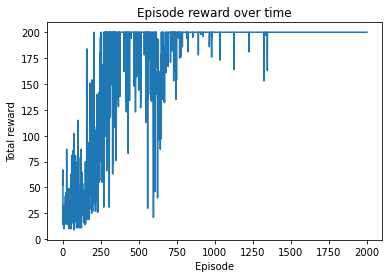

In [11]:
import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

# How it works
REINFORCE relies heavily on Monte Carlo methods to generate a whole trajectory used to
train the policy network. However, different actions may be taken in different episodes
under the same stochastic policy. To reduce the variance for the sampled experience, we
subtract the state-value from the return . The resulting advantage measures the reward
relative to the average action, which will be used in the gradient update.

REINFORCE with a baseline algorithm does the following tasks:
1. It runs an episode—es the state, reward, and the log policy at each step.
2. Once an episode finishes, it calculates the discounted cumulative reward at each
step; it estimates the baseline values using the value network; it computes the
advantage values by subtracting the baseline values from the returns.
3. It computes policy gradients using the advantage values and log probabilities,
and updates the policy and value networks. We also display the total reward for
each episode.
4.It runs n_episode episodes by repeating the aforementioned steps